<a href="https://colab.research.google.com/github/yuseongil034/git_test_markdown_sample/blob/main/0708_openCV_canny%2BHSV%2BGaussian_Block%2B%EB%85%B9%EC%83%89%EC%8B%A0%ED%98%B8%EB%93%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Google Colab 신호등 인식 테스트 ===
1. upload_and_detect() - 기본 검출
2. adjust_parameters_and_test() - 파라미터 비교 테스트

사용법:
upload_and_detect()  # 이 함수를 실행하세요
이미지 파일을 선택해주세요...


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042.png

처리중: KakaoTalk_20250708_085906042.png


/tmp/ipython-input-2-3967067028.py:117: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


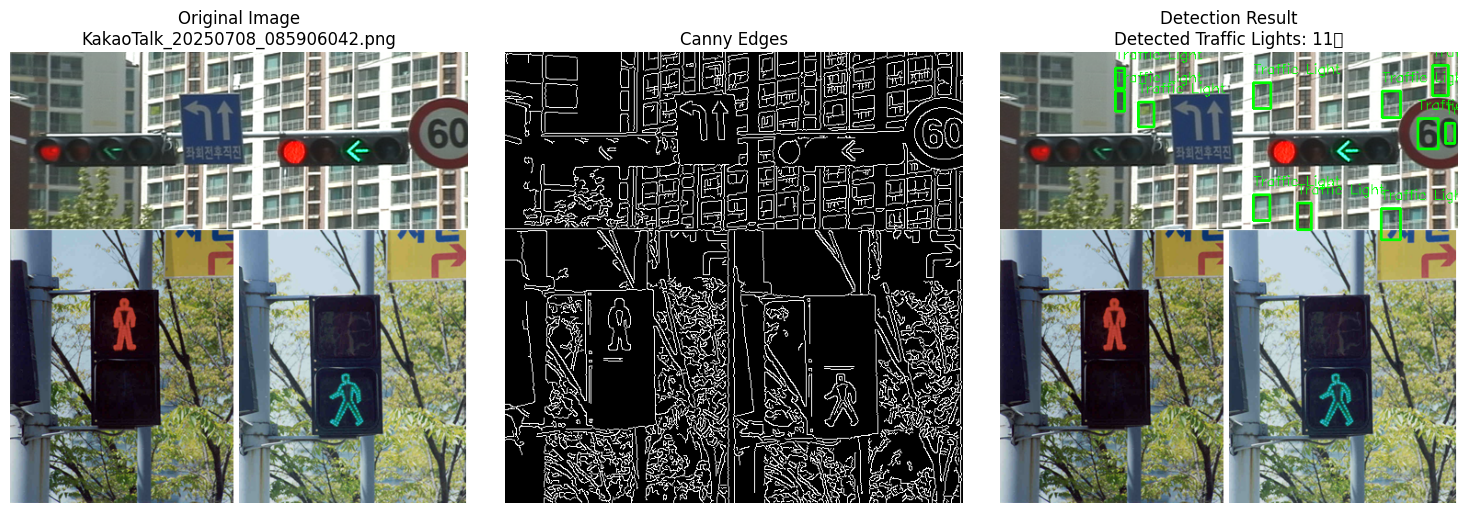

검출된 신호등 개수: 11
  신호등 1: 위치=(414, 170), 크기=(21x34)
  신호등 2: 위치=(323, 164), 크기=(15x29)
  신호등 3: 위치=(275, 155), 크기=(18x28)
  신호등 4: 위치=(484, 77), 크기=(10x22)
  신호등 5: 위치=(454, 72), 크기=(22x33)
  신호등 6: 위치=(150, 54), 크기=(17x27)
  신호등 7: 위치=(415, 42), 크기=(20x29)
  신호등 8: 위치=(125, 42), 크기=(10x22)
  신호등 9: 위치=(275, 33), 크기=(19x28)
  신호등 10: 위치=(125, 17), 크기=(10x22)
  신호등 11: 위치=(470, 14), 크기=(17x33)


In [2]:
# 1.결과 잡다한 신호등 인식 윗쪽 40퍼센트 정도만 감지 Google Colab에서 이미지 업로드하여 신호등 인식하기
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def detect_traffic_light_canny(image):
    """
    Canny 엣지 검출만을 사용한 신호등 인식
    """
    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 가우시안 블러로 노이즈 제거
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Canny 엣지 검출
    edges = cv2.Canny(blurred, 50, 150)

    # 컨투어 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    traffic_lights = []

    for contour in contours:
        # 컨투어 면적 필터링 (너무 작거나 큰 것 제외)
        area = cv2.contourArea(contour)
        if area < 100 or area > 5000:
            continue

        # 컨투어를 둘러싸는 사각형
        x, y, w, h = cv2.boundingRect(contour)

        # 종횡비 체크 (신호등은 대략 세로로 긴 형태)
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:  # 너무 가로로 긴 것 제외
            continue

        # 컨투어의 둘레와 면적으로 원형성 체크
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        # 원형에 가까운 것들만 선택 (신호등의 각 등은 원형)
        if circularity > 0.3:  # 임계값 조정 가능
            traffic_lights.append((x, y, w, h))

    return traffic_lights, edges

def draw_detections(image, detections):
    """
    검출된 신호등 영역을 이미지에 그리기
    """
    result = image.copy()
    for (x, y, w, h) in detections:
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, 'Traffic Light', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return result

def upload_and_detect():
    """
    Colab에서 이미지 업로드하고 신호등 검출
    """
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n처리중: {filename}")

        # 업로드된 이미지 읽기
        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))

        # PIL Image를 OpenCV 형식으로 변환
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # 이미지 크기 조정 (너무 크면 처리 시간이 오래 걸림)
        height, width = image_cv.shape[:2]
        if width > 800:
            ratio = 800 / width
            new_width = 800
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(image_cv)

        # 결과 이미지 생성
        result_image = draw_detections(image_cv, detections)

        # 결과 시각화 (matplotlib 사용)
        plt.figure(figsize=(15, 5))

        # 원본 이미지
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image\n{filename}')
        plt.axis('off')

        # Canny 엣지
        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny Edges')
        plt.axis('off')

        # 검출 결과
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Detection Result\nDetected Traffic Lights: {len(detections)}개')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # 검출 정보 출력
        print(f"검출된 신호등 개수: {len(detections)}")
        for i, (x, y, w, h) in enumerate(detections):
            print(f"  신호등 {i+1}: 위치=({x}, {y}), 크기=({w}x{h})")

def adjust_parameters_and_test():
    """
    파라미터를 조정하면서 테스트할 수 있는 함수
    """
    print("이미지 파일을 선택해주세요...")
    uploaded = files.upload()

    # 첫 번째 업로드된 이미지만 사용
    filename = list(uploaded.keys())[0]
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 이미지 크기 조정
    height, width = image_cv.shape[:2]
    if width > 800:
        ratio = 800 / width
        new_width = 800
        new_height = int(height * ratio)
        image_cv = cv2.resize(image_cv, (new_width, new_height))

    # 다양한 파라미터로 테스트
    test_params = [
        {"canny_low": 30, "canny_high": 100, "min_area": 50, "max_area": 3000, "circularity": 0.2},
        {"canny_low": 50, "canny_high": 150, "min_area": 100, "max_area": 5000, "circularity": 0.3},
        {"canny_low": 70, "canny_high": 200, "min_area": 200, "max_area": 8000, "circularity": 0.4}
    ]

    plt.figure(figsize=(20, 12))

    for i, params in enumerate(test_params):
        # 그레이스케일 변환
        gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Canny 엣지 검출 (파라미터 변경)
        edges = cv2.Canny(blurred, params["canny_low"], params["canny_high"])

        # 컨투어 찾기
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        traffic_lights = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < params["min_area"] or area > params["max_area"]:
                continue

            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(w) / h
            if aspect_ratio > 0.8:
                continue

            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue

            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity > params["circularity"]:
                traffic_lights.append((x, y, w, h))

        # 결과 그리기
        result = draw_detections(image_cv, traffic_lights)

        # 시각화
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'Original (Test {i+1})')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f'Result: {len(traffic_lights)}개 검출')
        plt.axis('off')

        print(f"Test {i+1} - 파라미터: {params}")
        print(f"  Detected Traffic Lights: {len(traffic_lights)}\n")

    plt.tight_layout()
    plt.show()

# 실행 함수들
print("=== Google Colab 신호등 인식 테스트 ===")
print("1. upload_and_detect() - 기본 검출")
print("2. adjust_parameters_and_test() - 파라미터 비교 테스트")
print("\n사용법:")
print("upload_and_detect()  # 이 함수를 실행하세요")

# 바로 실행하려면 아래 주석을 해제하세요
upload_and_detect()

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🚀 신호등 인식 프로그램 시작! (개선된 버전)
📁 이미지 파일을 선택해주세요...


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042 (3).png

🖼️  파일 처리 시작: KakaoTalk_20250708_085906042 (3).png
이미지 크기: 498 x 491 픽셀

🔍 신호등 검출 시작... (색상 필터링 + Canny)
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 30-120)
Step 4: 825개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 13 검사 중...
    ❌ 너무 작음 (면적: 2.5, 최소: 100)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 100)
  윤곽선 15 검사 중...


/tmp/ipython-input-11-3582470699.py:382: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-3582470699.py:382: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-3582470699.py:382: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-3582470699.py:382: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-3582470699.py:382: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-3582470699.py:382: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-3582470699.py:382: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu S

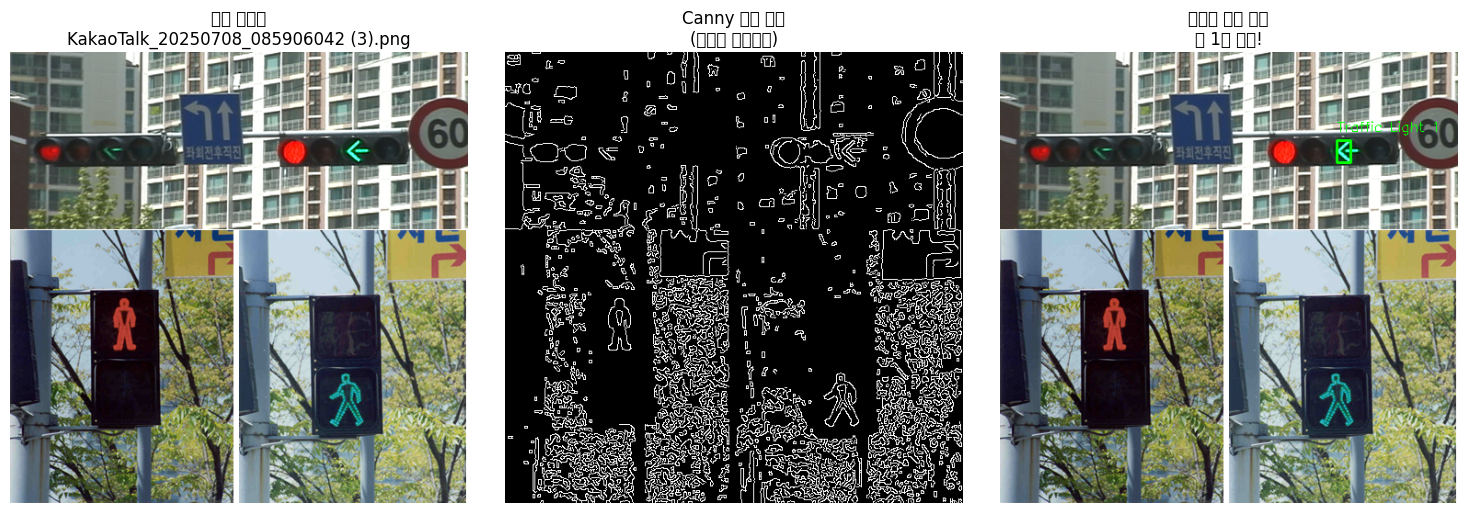


📋 최종 결과:
   검출된 신호등 개수: 1개
   🚦 신호등 1: 위치=(366, 96), 크기=(15 x 24)


In [11]:
# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 20, 20])
        red_upper1 = np.array([10, 255, 255])
        red_lower2 = np.array([160, 20, 20])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([11, 30, 30])
        red_upper3 = np.array([20, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.7:  # 이미지 하단 30%에 있으면 제외
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2: 결과를 그림으로 그리는 함수
# ============================================
def draw_detections(image, detections):
    """
    찾은 신호등 위치에 초록색 사각형을 그리는 함수
    """
    result = image.copy()

    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return result

# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")
def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본 이미지')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개\n면적:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=100,     # 최적화된 파라미터
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본 이미지\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지 검출\n(개선된 파라미터)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'신호등 검출 결과\n🚦 {len(detections)}개 발견!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 개수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=100,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요
upload_and_detect()
#upload_multiple_images()
# adjust_parameters_and_test()

2번째 코드

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🚀 신호등 인식 프로그램 시작! (개선된 버전)
📁 이미지 파일을 선택해주세요...


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042 (23).png

🖼️  파일 처리 시작: KakaoTalk_20250708_085906042 (23).png
이미지 크기: 498 x 491 픽셀

🔍 신호등 검출 시작... (색상 필터링 + Canny)
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 30-120)
Step 4: 823개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 100)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 0.5, 최소: 100)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 100)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 1.5, 최소: 100)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 13 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 100)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 2.5, 최소: 100)
  윤곽선 15 검사 중..

/tmp/ipython-input-37-1593744262.py:382: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-1593744262.py:382: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-1593744262.py:382: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-1593744262.py:382: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-1593744262.py:382: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-1593744262.py:382: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-37-1593744262.py:382: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu S

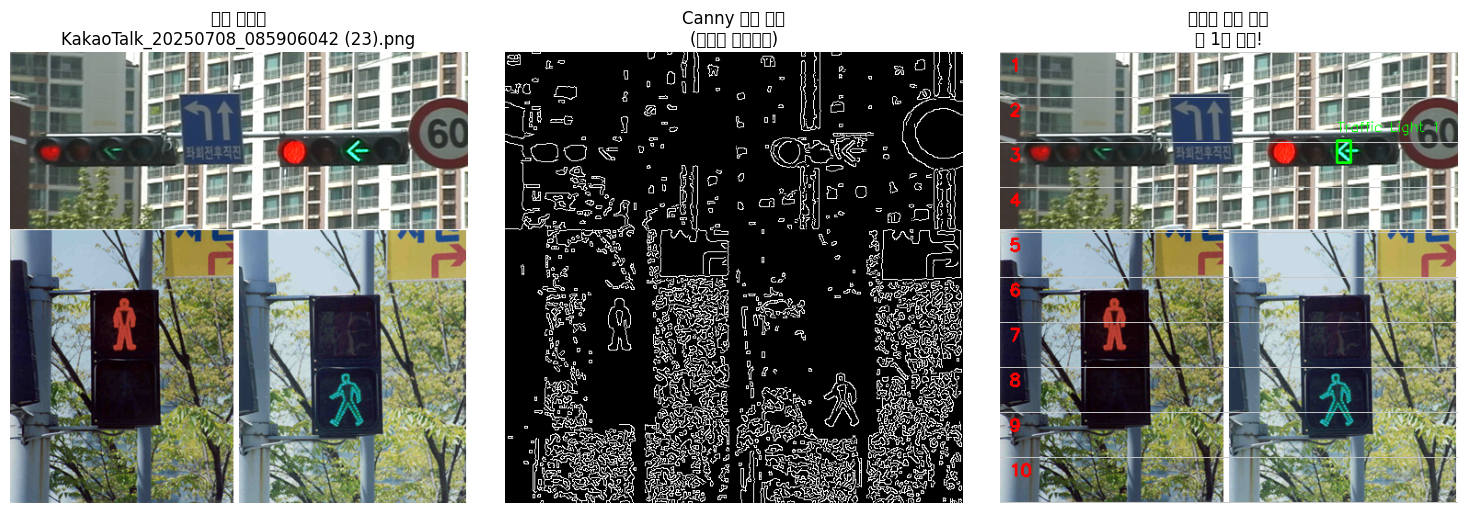


📋 최종 결과:
   검출된 신호등 개수: 1개
   🚦 신호등 1: 위치=(366, 96), 크기=(15 x 24)


In [37]:
# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 30, 30])
        red_upper1 = np.array([15, 255, 255])
        red_lower2 = np.array([160, 20, 20])
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([11, 30, 30])
        red_upper3 = np.array([20, 255, 255])

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.9:  # 이미지 하단 30%에 있으면 제외
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.8:
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter)

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2: 결과를 그림으로 그리는 함수
# ============================================
def draw_detections(image, detections):
    """
    찾은 신호등 위치에 초록색 사각형을 그리는 함수
    """
    result = image.copy()

    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return result

# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")
def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본 이미지')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개\n면적:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=100,     # 최적화된 파라미터
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본 이미지\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지 검출\n(개선된 파라미터)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'신호등 검출 결과\n🚦 {len(detections)}개 발견!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 개수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=100,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break


def draw_detections(image, detections, draw_grid=True, grid_rows=10):
    result = image.copy()
    height, width = result.shape[:2]
    label_color = (0, 0, 255)  # 빨간색 (BGR)
    if draw_grid:
        row_height = height // grid_rows
        for i in range(grid_rows):
            y = i * row_height
            cv2.line(result, (0, y), (width, y), (200, 200, 200), 1)
            label = str(i + 1)  # 1부터 10까지 표기
            cv2.putText(result, label, (10, y + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, label_color, 2)
        # 마지막 선만 그리고, 숫자는 추가하지 않음
        cv2.line(result, (0, height - 1), (width, height - 1), (200, 200, 200), 1)
    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return result


def detect_crosswalk_signals(image, min_area=50, max_area=10000, canny_low=30, canny_high=120, circularity_threshold=0.15):
    import cv2
    import numpy as np
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 빨간불(두 구간)
    red_lower1 = np.array([0, 30, 30])
    red_upper1 = np.array([15, 255, 255])
    red_lower2 = np.array([165, 30, 30])
    red_upper2 = np.array([180, 255, 255])
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # 파란불
    blue_lower = np.array([80, 30, 30])
    blue_upper = np.array([120, 255, 255])
    blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

    # 빨간불 검출
    red_filtered = cv2.bitwise_and(image, image, mask=red_mask)
    gray_red = cv2.cvtColor(red_filtered, cv2.COLOR_BGR2GRAY)
    blurred_red = cv2.GaussianBlur(gray_red, (9, 9), 0)
    edges_red = cv2.Canny(blurred_red, canny_low, canny_high)
    contours_red, _ = cv2.findContours(edges_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    red_signals = []
    for cnt in contours_red:
        area = cv2.contourArea(cnt)
        if area < min_area or area > max_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        if aspect_ratio > 1.0:
            continue
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > circularity_threshold:
            red_signals.append((x, y, w, h))

    # 파란불 검출
    blue_filtered = cv2.bitwise_and(image, image, mask=blue_mask)
    gray_blue = cv2.cvtColor(blue_filtered, cv2.COLOR_BGR2GRAY)
    blurred_blue = cv2.GaussianBlur(gray_blue, (9, 9), 0)
    edges_blue = cv2.Canny(blurred_blue, canny_low, canny_high)
    contours_blue, _ = cv2.findContours(edges_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    blue_signals = []
    for cnt in contours_blue:
        area = cv2.contourArea(cnt)
        if area < min_area or area > max_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        if aspect_ratio > 1.0:
            continue
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > circularity_threshold:
            blue_signals.append((x, y, w, h))

    return red_signals, blue_signals



def draw_crosswalk_signals(image, red_signals, blue_signals, draw_grid=True, grid_rows=10):
    import cv2
    result = image.copy()
    height, width = result.shape[:2]

    # 격자선 및 번호
    if draw_grid:
        row_height = height // grid_rows
        for i in range(grid_rows):
            y = i * row_height
            cv2.line(result, (0, y), (width, y), (200, 200, 200), 1)
            label = str(i + 1)
            cv2.putText(result, label, (10, y + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.line(result, (0, height - 1), (width, height - 1), (200, 200, 200), 1)

    # 빨간불 신호: 빨간색 사각형
    for i, (x, y, w, h) in enumerate(red_signals):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(result, f'Ped Red {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # 파란불 신호: 파란색 사각형
    for i, (x, y, w, h) in enumerate(blue_signals):
        cv2.rectangle(result, (x, y), (x + w, y + h), (255, 140, 0), 2)
        cv2.putText(result, f'Ped Blue {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 140, 0), 1)

    return result













# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요
upload_and_detect()
#upload_multiple_images()
# adjust_parameters_and_test()

🚦 개선된 신호등 인식 프로그램

🎯 실행 옵션을 선택하세요:

1️⃣ upload_and_detect()          - 색상 필터링 + Canny
2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트
3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트
4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교

🔧 주요 개선 사항:
   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출
   - 면적 범위: 100~8000 (최적화)
   - Canny 임계값: 30-120
   - 원형성 기준: 0.25
   - 위치 필터링: 하단 30% 제외
   - 종횡비: 0.8 이하
   - 이미지 크기: 최대 1200px

💡 추천 순서:
   1. compare_with_without_color() - 색상 필터링 효과 확인
   2. upload_multiple_images() - 여러 사진으로 테스트

🚀 신호등 인식 프로그램 시작! (개선된 버전)
📁 이미지 파일을 선택해주세요...


Saving KakaoTalk_20250708_085906042.png to KakaoTalk_20250708_085906042 (15).png

🖼️  파일 처리 시작: KakaoTalk_20250708_085906042 (15).png
이미지 크기: 498 x 491 픽셀

🔍 신호등 검출 시작... (색상 필터링 + Canny)
Step 0: 신호등 색상 필터링 시작...
Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)
Step 2: 노이즈 제거 완료
Step 3: 엣지 검출 완료 (임계값: 30-120)
Step 4: 500개의 윤곽선 발견
  윤곽선 1 검사 중...
    ❌ 너무 작음 (면적: 3.5, 최소: 120)
  윤곽선 2 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 120)
  윤곽선 3 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 120)
  윤곽선 4 검사 중...
    ❌ 너무 작음 (면적: 0.0, 최소: 120)
  윤곽선 5 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 120)
  윤곽선 6 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 120)
  윤곽선 7 검사 중...
    ❌ 너무 작음 (면적: 2.0, 최소: 120)
  윤곽선 8 검사 중...
    ❌ 너무 작음 (면적: 4.5, 최소: 120)
  윤곽선 9 검사 중...
    ❌ 너무 작음 (면적: 1.0, 최소: 120)
  윤곽선 10 검사 중...
    ❌ 너무 작음 (면적: 18.5, 최소: 120)
  윤곽선 11 검사 중...
    ❌ 너무 작음 (면적: 3.0, 최소: 120)
  윤곽선 12 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 120)
  윤곽선 13 검사 중...
    ❌ 너무 작음 (면적: 4.0, 최소: 120)
  윤곽선 14 검사 중...
    ❌ 너무 작음 (면적: 9.0, 최소: 120)
  윤곽선 15 검사 중.

/tmp/ipython-input-18-1150988274.py:384: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-1150988274.py:384: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-1150988274.py:384: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-1150988274.py:384: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-1150988274.py:384: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-1150988274.py:384: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-1150988274.py:384: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu S

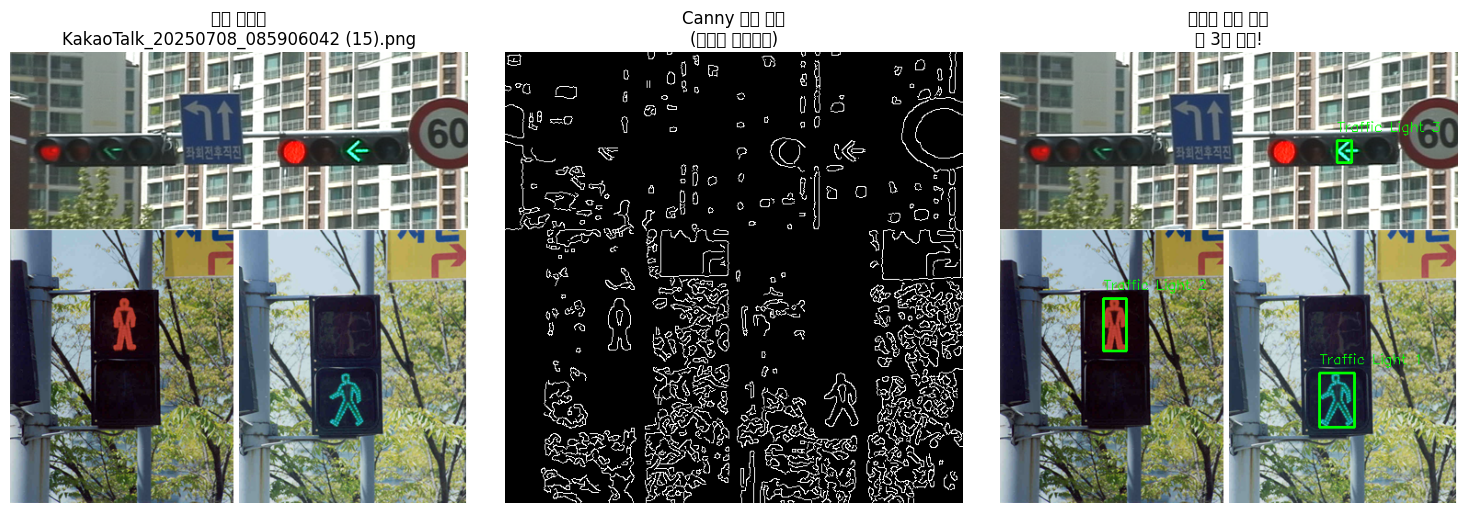


📋 최종 결과:
   검출된 신호등 개수: 3개
   🚦 신호등 1: 위치=(347, 349), 크기=(38 x 59)
   🚦 신호등 2: 위치=(112, 268), 크기=(25 x 57)
   🚦 신호등 3: 위치=(366, 96), 크기=(16 x 24)


In [18]:
# ============================================
# 3 초보자를 위한 신호등 인식 코드 상세 설명
# ============================================

# 1. 필요한 라이브러리들 가져오기
import cv2          # 컴퓨터 비전 라이브러리 (이미지 처리용)
import numpy as np  # 숫자 계산용 라이브러리
import matplotlib.pyplot as plt  # 그래프/이미지 표시용
from google.colab import files   # 코랩에서 파일 업로드용
from PIL import Image           # 이미지 파일 읽기용
import io                      # 파일 입출력용

# ============================================
# 메인 함수 1: 신호등 찾는 함수 (색상 필터링 + Canny)
# ============================================
def detect_traffic_light_canny(image, min_area=100, max_area=8000, canny_low=30, canny_high=120, circularity_threshold=0.25, use_color_filter=True):
    """
    이 함수는 사진에서 신호등을 찾는 함수입니다 (색상 필터링 + Canny)
    입력: 컬러 사진, 최소면적, 최대면적, Canny 임계값들, 원형성 기준, 색상필터 사용여부
    출력: 신호등 위치들, 엣지 이미지
    """

    # 🔴 NEW Step: 색상 필터링 (신호등 색상만 찾기)
    if use_color_filter:
        print("Step 0: 신호등 색상 필터링 시작...")

        # HSV 색공간으로 변환 (색상 검출에 더 좋음)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # 빨강색 범위 (신호등 빨간불)
        red_lower1 = np.array([0, 30, 30]) # 20에서 30으로
        red_upper1 = np.array([15, 255, 255]) #10에서 15
        red_lower2 = np.array([165, 30, 30]) #165로 30으로
        red_upper2 = np.array([180, 255, 255])
        red_lower3 = np.array([1, 20, 20]) #해당 값으로 수정함
        red_upper3 = np.array([10, 255, 150]) #해당 값으로 수정함
        red_lower4 = np.array([170, 50, 100]) #추가함
        red_upper4 = np.array([180, 255, 255]) #추가함

        # 노랑색 범위 (신호등 노란불)
        yellow_lower = np.array([20, 50, 50])
        yellow_upper = np.array([30, 255, 255])
        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        # 초록색 범위 (신호등 초록불)
        green_lower = np.array([40, 50, 50])
        green_upper = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        # 파란색/청록색 범위 (보행자 신호등 파란불) 🆕 추가!
        blue_lower = np.array([80, 50, 50])
        blue_upper = np.array([100, 255, 255])
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)
        # 각 색상 마스크 생성
        red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
        red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
        green_mask = cv2.inRange(hsv, green_lower, green_upper)
        blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)  # 🆕 파란색 마스크 추가!
        red_mask3 = cv2.inRange(hsv, red_lower3, red_upper3)
        red_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask1, red_mask2), red_mask3)

        # 모든 신호등 색상 마스크 합치기 (파란색 포함)
        traffic_light_mask = red_mask
       # traffic_light_mask = cv2.bitwise_or(red_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, yellow_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, green_mask)
        traffic_light_mask = cv2.bitwise_or(traffic_light_mask, blue_mask)  # 🆕 파란색도 추가!

        # 마스크를 원본 이미지에 적용
        color_filtered = cv2.bitwise_and(image, image, mask=traffic_light_mask)

        # 색상 필터링된 이미지를 흑백으로 변환
        gray = cv2.cvtColor(color_filtered, cv2.COLOR_BGR2GRAY)
        print("Step 0: 색상 필터링 완료 (빨강/노랑/초록/파랑 영역만 추출)")
    else:
        # 색상 필터링 없이 바로 흑백 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Step 1: 컬러 → 흑백 변환 완료 (색상 필터링 없음)")

    # 🟡 Step 2: 이미지를 부드럽게 만들기 (노이즈 제거)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0) #9로 3은 신호등 두 개는 인식하지 못하고 5는 하나만 인식 9로하면 세개인식
    print("Step 2: 노이즈 제거 완료")

    # 🟡 Step 3: Canny 엣지 검출 (파라미터 조정됨!)
    edges = cv2.Canny(blurred, canny_low, canny_high)  # 조정 가능한 값들
    print(f"Step 3: 엣지 검출 완료 (임계값: {canny_low}-{canny_high})")

    # 🟡 Step 4: 엣지들로 윤곽선(컨투어) 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Step 4: {len(contours)}개의 윤곽선 발견")

    # 🟡 Step 5: 찾은 윤곽선들 중에서 신호등 같은 것만 골라내기
    traffic_lights = []
    image_height = image.shape[0]  # 이미지 높이 구하기

    for i, contour in enumerate(contours):
        print(f"  윤곽선 {i+1} 검사 중...")

        # 📏 크기 체크: 조정된 면적 범위 사용
        area = cv2.contourArea(contour)
        if area < min_area:  # 조정 가능한 최소 면적
            print(f"    ❌ 너무 작음 (면적: {area}, 최소: {min_area})")
            continue
        if area > max_area:  # 조정 가능한 최대 면적
            print(f"    ❌ 너무 큼 (면적: {area}, 최대: {max_area})")
            continue

        # 📐 윤곽선을 둘러싸는 사각형 구하기
        x, y, w, h = cv2.boundingRect(contour)
       # 위치필터링 추가
        # 🆕 위치 필터링: 신호등은 보통 이미지 상단에 있음
        if y > image_height * 0.8:  # 이미지 하단 30%에 있으면 제외 #0.7>0.8
            print(f"    ❌ 너무 아래쪽 (y: {y}, 이미지 높이의 {y/image_height*100:.1f}%)")
            continue

        # 📏 가로세로 비율 체크: 신호등은 세로가 더 김
        aspect_ratio = float(w) / h
        if aspect_ratio > 0.7: #0.8>0.7, 0.6은 감지 아무것도 못함
            print(f"    ❌ 너무 가로로 김 (비율: {aspect_ratio:.2f})")
            continue

        # 🔵 원형성 체크: 조정된 기준 사용
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * area / (perimeter * perimeter) #건들이지 말것, 3으로두면 아무것도 인식하지 못하고 5로 두면 잡동사니가 인식됨

        if circularity > circularity_threshold:  # 조정 가능한 원형성 기준
            print(f"    ✅ 신호등 후보 발견! (면적: {area}, 비율: {aspect_ratio:.2f}, 원형성: {circularity:.2f}, 위치: y={y})")
            traffic_lights.append((x, y, w, h))
        else:
            print(f"    ❌ 원형이 아님 (원형성: {circularity:.2f}, 기준: {circularity_threshold})")

    print(f"최종 결과: {len(traffic_lights)}개의 신호등 발견!")
    return traffic_lights, edges

# ============================================
# 메인 함수 2: 결과를 그림으로 그리는 함수
# ============================================
def draw_detections(image, detections):
    """
    찾은 신호등 위치에 초록색 사각형을 그리는 함수
    """
    result = image.copy()

    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f'Traffic Light {i+1}', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return result

# ============================================
# 🆕 색상 필터링 비교 테스트 함수
# ============================================
def compare_with_without_color():
    """
    색상 필터링 있을 때 vs 없을 때 비교
    """
    print("🎨 색상 필터링 비교 테스트!")
    print("📁 신호등 사진을 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 1. 색상 필터링 없이 검출
    print("\n🔍 테스트 1: 색상 필터링 없이")
    detections1, edges1 = detect_traffic_light_canny(
        image_cv,
        min_area=120, max_area=8000, #####
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=False  # 색상 필터링 사용 안함
    )

    # 2. 색상 필터링 사용해서 검출
    print("\n🔍 테스트 2: 색상 필터링 사용")
    detections2, edges2 = detect_traffic_light_canny(
        image_cv,
        min_area=100, max_area=8000,
        canny_low=30, canny_high=120,
        circularity_threshold=0.25,
        use_color_filter=True   # 색상 필터링 사용!
    )

    # 결과 이미지 생성
    result1 = draw_detections(image_cv, detections1)
    result2 = draw_detections(image_cv, detections2)

    # 비교 결과 표시
    plt.figure(figsize=(20, 10))

    # 첫 번째 줄: 색상 필터링 없는 경우
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f'원본 이미지\n{filename}')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(edges1, cmap='gray')
    plt.title('Canny만 사용\n(색상 필터링 없음)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections1)}개 검출\n(색상 필터링 없음)')
    plt.axis('off')

    # 두 번째 줄: 색상 필터링 있는 경우
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title('원본 이미지')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges2, cmap='gray')
    plt.title('색상 필터링 + Canny\n(빨강/노랑/초록만)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
    plt.title(f'결과: {len(detections2)}개 검출\n(색상 필터링 적용)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 비교
    print(f"\n📊 결과 비교:")
    print(f"   색상 필터링 없음: {len(detections1)}개 검출")
    print(f"   색상 필터링 적용: {len(detections2)}개 검출")

    if len(detections2) > 0 and len(detections2) <= len(detections1):
        print("   ✅ 색상 필터링이 더 정확한 결과를 보여줍니다!")
    elif len(detections2) > len(detections1):
        print("   📈 색상 필터링으로 더 많은 신호등을 찾았습니다!")
    else:
        print("   🤔 두 방법 모두 신호등을 찾지 못했습니다. 다른 사진을 시도해보세요.")
def adjust_parameters_and_test():
    """
    다양한 파라미터로 테스트해서 최적값 찾기
    """
    print("🔧 파라미터 조정 테스트 모드!")
    print("📁 신호등이 있는 이미지를 선택하세요...")

    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    # 이미지 로드
    image_data = uploaded[filename]
    image = Image.open(io.BytesIO(image_data))
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # 크기 조정
    height, width = image_cv.shape[:2]
    if width > 1000:
        ratio = 1000 / width
        image_cv = cv2.resize(image_cv, (1000, int(height * ratio)))

    # 다양한 파라미터 조합 테스트
    param_sets = [
        {"name": "기본값", "min_area": 100, "max_area": 5000, "canny_low": 50, "canny_high": 150, "circularity": 0.3},
        {"name": "더 민감하게", "min_area": 50, "max_area": 10000, "canny_low": 30, "canny_high": 120, "circularity": 0.2},
        {"name": "더 엄격하게", "min_area": 200, "max_area": 8000, "canny_low": 70, "canny_high": 200, "circularity": 0.4},
        {"name": "큰 신호등용", "min_area": 500, "max_area": 15000, "canny_low": 40, "canny_high": 160, "circularity": 0.25}
    ]

    plt.figure(figsize=(20, 15))

    for i, params in enumerate(param_sets):
        print(f"\n🧪 테스트 {i+1}: {params['name']}")

        # 신호등 검출
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=params["min_area"],
            max_area=params["max_area"],
            canny_low=params["canny_low"],
            canny_high=params["canny_high"],
            circularity_threshold=params["circularity"]
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시 (4행 3열 그리드)
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'{params["name"]}\n원본 이미지')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny {params["canny_low"]}-{params["canny_high"]}')
        plt.axis('off')

        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'결과: {len(detections)}개\n면적:{params["min_area"]}-{params["max_area"]}')
        plt.axis('off')

        print(f"   📊 {params['name']}: {len(detections)}개 검출")

    plt.tight_layout()
    plt.show()

    print("\n📝 어떤 설정이 가장 좋았나요?")
    print("   가장 잘 나온 파라미터를 기본값으로 사용하세요!")

# ============================================
# 기본 함수 (파라미터 자동 조정)
# ============================================
def upload_and_detect():
    """
    개선된 파라미터로 신호등 검출
    """
    print("🚀 신호등 인식 프로그램 시작! (개선된 버전)")
    print("📁 이미지 파일을 선택해주세요...")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n🖼️  파일 처리 시작: {filename}")

        image_data = uploaded[filename]
        image = Image.open(io.BytesIO(image_data))
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        print(f"이미지 크기: {image_cv.shape[1]} x {image_cv.shape[0]} 픽셀")

        # 크기 조정 (더 큰 크기 유지)
        height, width = image_cv.shape[:2]
        if width > 1200:  # 기존 800에서 1200으로 증가
            ratio = 1200 / width
            new_width = 1200
            new_height = int(height * ratio)
            image_cv = cv2.resize(image_cv, (new_width, new_height))
            print(f"크기 조정: {new_width} x {new_height}")

        # 개선된 파라미터로 신호등 찾기
        print("\n🔍 신호등 검출 시작... (색상 필터링 + Canny)")
        detections, edges = detect_traffic_light_canny(
            image_cv,
            min_area=120,     # 최적화된 파라미터  #100>120으로 변경하니 신호등이 아닌 것 하나 삭제됨
            max_area=8000,
            canny_low=30,
            canny_high=120,
            circularity_threshold=0.25,
            use_color_filter=True      # 🆕 색상 필터링 사용!
        )

        result_image = draw_detections(image_cv, detections)

        # 결과 표시
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
        plt.title(f'원본 이미지\n{filename}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny 엣지 검출\n(개선된 파라미터)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f'신호등 검출 결과\n🚦 {len(detections)}개 발견!')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\n📋 최종 결과:")
        print(f"   검출된 신호등 개수: {len(detections)}개")

        if len(detections) > 0:
            for i, (x, y, w, h) in enumerate(detections):
                print(f"   🚦 신호등 {i+1}: 위치=({x}, {y}), 크기=({w} x {h})")
        else:
            print("   😅 신호등을 찾지 못했습니다.")

# ============================================
# 여러 사진 테스트 (개선된 버전)
# ============================================
def upload_multiple_images():
    """
    여러 사진을 연속으로 업로드해서 테스트하는 함수 (개선된 파라미터)
    """
    print("🚀 여러 사진 연속 테스트 모드! (개선된 버전)")

    while True:
        print("\n" + "="*50)
        print("📁 새로운 이미지를 업로드하세요")

        try:
            uploaded = files.upload()

            if not uploaded:
                print("👋 업로드가 취소되었습니다.")
                break

            for filename in uploaded.keys():
                print(f"\n🖼️  파일 처리: {filename}")

                image_data = uploaded[filename]
                image = Image.open(io.BytesIO(image_data))
                image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                # 크기 조정
                height, width = image_cv.shape[:2]
                if width > 1200:
                    ratio = 1200 / width
                    new_width = 1200
                    new_height = int(height * ratio)
                    image_cv = cv2.resize(image_cv, (new_width, new_height))
                    print(f"📏 크기 조정: {width}x{height} → {new_width}x{new_height}")

                # 색상 필터링 + Canny로 검출
                detections, edges = detect_traffic_light_canny(
                    image_cv,
                    min_area=200,
                    max_area=8000,
                    canny_low=30,
                    canny_high=120,
                    circularity_threshold=0.25,
                    use_color_filter=True  # 🆕 색상 필터링 사용!
                )

                result_image = draw_detections(image_cv, detections)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
                plt.title(f'원본: {filename}')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(edges, cmap='gray')
                plt.title('Canny 엣지')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
                plt.title(f'검출 결과\n🚦 {len(detections)}개 발견')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                print(f"📋 결과: {len(detections)}개 신호등 검출")
                for i, (x, y, w, h) in enumerate(detections):
                    print(f"   🚦 신호등 {i+1}: ({x}, {y}) 크기 {w}x{h}")

            response = input("\n🔄 다른 사진도 테스트하시겠습니까? (y/n): ").lower()
            if response not in ['y', 'yes', '예', 'ㅇ']:
                print("👋 테스트를 종료합니다!")
                break

        except Exception as e:
            print(f"❌ 오류 발생: {e}")
            break

def draw_crosswalk_signals(image, red_signals, blue_signals, draw_grid=True, grid_rows=10):
    import cv2
    result = image.copy()
    height, width = result.shape[:2]

    # 격자선 및 번호
    if draw_grid:
        row_height = height // grid_rows
        for i in range(grid_rows):
            y = i * row_height
            cv2.line(result, (0, y), (width, y), (200, 200, 200), 1)
            label = str(i + 1)
            cv2.putText(result, label, (10, y + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.line(result, (0, height - 1), (width, height - 1), (200, 200, 200), 1)

    # 빨간불 신호: 빨간색 사각형
    for i, (x, y, w, h) in enumerate(red_signals):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(result, f'Ped Red {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # 파란불 신호: 파란색 사각형
    for i, (x, y, w, h) in enumerate(blue_signals):
        cv2.rectangle(result, (x, y), (x + w, y + h), (255, 140, 0), 2)
        cv2.putText(result, f'Ped Blue {i+1}', (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 140, 0), 1)

    return result



# ============================================
# 🎯 실행 옵션들
# ============================================
print("=" * 50)
print("🚦 개선된 신호등 인식 프로그램")
print("=" * 50)
print()
print("🎯 실행 옵션을 선택하세요:")
print()
print("1️⃣ upload_and_detect()          - 색상 필터링 + Canny")
print("2️⃣ upload_multiple_images()     - 여러 사진 연속 테스트")
print("3️⃣ adjust_parameters_and_test() - 파라미터 비교 테스트")
print("4️⃣ compare_with_without_color()  - 색상 필터링 효과 비교")
print()
print("🔧 주요 개선 사항:")
print("   - 🎨 색상 필터링 추가: 빨강/노랑/초록/파랑 신호등 색상만 검출")
print("   - 면적 범위: 100~8000 (최적화)")
print("   - Canny 임계값: 30-120")
print("   - 원형성 기준: 0.25")
print("   - 위치 필터링: 하단 30% 제외")
print("   - 종횡비: 0.8 이하")
print("   - 이미지 크기: 최대 1200px")
print()
print("💡 추천 순서:")
print("   1. compare_with_without_color() - 색상 필터링 효과 확인")
print("   2. upload_multiple_images() - 여러 사진으로 테스트")
print()

# 바로 실행하려면 아래 중 하나의 주석을 해제하세요
upload_and_detect()
#upload_multiple_images()
# adjust_parameters_and_test()